In [2]:
!pip install kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abdullahnasser","key":"4fc39131739e56c8d0c792b31085a58b"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d ashishpatel26/facial-expression-recognitionferchallenge

 84% 81.0M/96.6M [00:01<00:00, 45.3MB/s]
100% 96.6M/96.6M [00:01<00:00, 54.1MB/s]


In [6]:
!ls

facial-expression-recognitionferchallenge.zip  kaggle.json  sample_data


In [7]:
import zipfile
zip_ref = zipfile.ZipFile('facial-expression-recognitionferchallenge.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

In [100]:
import pandas as pd
data = pd.read_csv(r'/content/files/fer2013/fer2013/fer2013.csv')
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


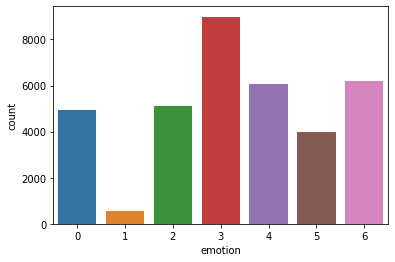

In [101]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.countplot(data.emotion)

It is evident that majority of the data is in classes {0, 2, 3, 4, 6}.
So we will use those classes only

In [102]:
data['Usage'].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [103]:
data = data.query('emotion==0 or emotion==2 or emotion==3 or emotion==4 or emotion==6')

In [104]:
#Split the data into traing and testing
data_train = data.query('Usage=="Training" or Usage == "PublicTest"')
data_test = data.query('Usage=="PrivateTest"')

In [105]:
data_train.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [106]:
X_train = data_train.iloc[:,1]
y_train = data_train.iloc[:,0]

X_test = data_test.iloc[:,1]
y_test = data_test.iloc[:,0]

In [107]:
print(X_train.shape)

(28220,)


In [108]:
#Make the data ready for CNN
import numpy as np

X_train = X_train.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
X_train = np.stack(X_train, axis=0)

X_test = X_test.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
X_test = np.stack(X_test, axis=0)

In [109]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [110]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

num_classes = 5
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_train = np_utils.to_categorical(y_train, num_classes)

y_test = le.fit_transform(y_test)
y_test = np_utils.to_categorical(y_test, num_classes)



In [111]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(28220, 48, 48, 1)
(3118, 48, 48, 1)
(28220, 5)
(3118, 5)


In [112]:
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=2, activation='relu', input_shape=(48,48,1)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))


model.add(Conv2D(filters=256, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=512, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=1))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 47, 47, 32)        160       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 22, 22, 64)        8256      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 128)       32896     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 128)        

In [113]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [114]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

early = EarlyStopping(
        monitor='val_accuracy', 
        patience=10,
        mode='max',
        restore_best_weights=True,
        verbose=1)

checkpointer = ModelCheckpoint(filepath='FER.hdf5', verbose=1, save_best_only=True)

In [51]:
hist = model.fit(X_train, y_train, batch_size=128, epochs=150, validation_split=0.2, callbacks=[checkpointer, early], verbose=1, shuffle=True)

Epoch 1/150
177/177 [==============================] - 2s 13ms/step - loss: 0.3671 - accuracy: 0.8717 - val_loss: 1.3819 - val_accuracy: 0.5737

Epoch 00001: val_loss improved from inf to 1.38190, saving model to FER.hdf5
Epoch 2/150
177/177 [==============================] - 2s 12ms/step - loss: 0.3692 - accuracy: 0.8664 - val_loss: 1.3713 - val_accuracy: 0.5691

Epoch 00002: val_loss improved from 1.38190 to 1.37134, saving model to FER.hdf5
Epoch 3/150
177/177 [==============================] - 2s 11ms/step - loss: 0.3529 - accuracy: 0.8718 - val_loss: 1.3864 - val_accuracy: 0.5742

Epoch 00003: val_loss did not improve from 1.37134
Epoch 4/150
177/177 [==============================] - 2s 11ms/step - loss: 0.3607 - accuracy: 0.8707 - val_loss: 1.3636 - val_accuracy: 0.5744

Epoch 00004: val_loss improved from 1.37134 to 1.36356, saving model to FER.hdf5
Epoch 5/150
177/177 [==============================] - 2s 12ms/step - loss: 0.3510 - accuracy: 0.8742 - val_loss: 1.4189 - val_acc

In [52]:
model.load_weights('FER.hdf5')

In [53]:
score = model.evaluate(X_test, y_test, verbose=0)

In [54]:
print(score[1])

0.5859525203704834


So by training my own CNN I was able to get an accuracy of  58.5%

In [115]:
from keras.applications.vgg16 import VGG16

In [116]:
#The data is grayscale, and VGG is trained on RGB images.
#So to get around this issue

from keras import backend as K

def grayscale_to_rgb(images, channel_axis=-1):
    #images= K.expand_dims(images, axis=channel_axis)
    tiling = [1] * 4    # 4 dimensions: B, H, W, C
    tiling[channel_axis] *= 3
    images= K.tile(images, tiling)
    return images

In [117]:
X_train = grayscale_to_rgb(X_train)
X_test = grayscale_to_rgb(X_test)

In [118]:
print(X_train.shape)
print(X_test.shape)

(28220, 48, 48, 3)
(3118, 48, 48, 3)


In [119]:
model_vgg = VGG16(include_top=False, weights='imagenet', input_shape=[48,48,3])

In [120]:
#Not to train the entire model
for layer in model_vgg.layers:
  layer.trainable=False

In [121]:
#Add last fully connected layers

x = Flatten()(model_vgg.output)
prediction = Dense(5,activation='softmax')(x)

In [122]:
from keras.models import Model
model_vgg1 = Model(inputs=model_vgg.input, outputs=prediction)

In [123]:
model_vgg1.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0   

In [124]:
model_vgg1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [125]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

early = EarlyStopping(
        monitor='val_accuracy', 
        patience=10,
        mode='max',
        restore_best_weights=True,
        verbose=1)

checkpointer = ModelCheckpoint(filepath='FER.vgg.hdf5', verbose=1, save_best_only=True)

In [127]:
y_train.shape

(28220, 5)

In [128]:
hist = model_vgg1.fit(X_train, y_train, batch_size=128, epochs=150,
                 validation_split=0.2, callbacks=[checkpointer, early], verbose=1, shuffle=True)

Epoch 1/150
177/177 [==============================] - 8s 40ms/step - loss: 13.7512 - accuracy: 0.2450 - val_loss: 4.6032 - val_accuracy: 0.3154

Epoch 00001: val_loss improved from inf to 4.60324, saving model to FER.vgg.hdf5
Epoch 2/150
177/177 [==============================] - 6s 37ms/step - loss: 3.7204 - accuracy: 0.3245 - val_loss: 2.4079 - val_accuracy: 0.3409

Epoch 00002: val_loss improved from 4.60324 to 2.40785, saving model to FER.vgg.hdf5
Epoch 3/150
177/177 [==============================] - 6s 37ms/step - loss: 2.0229 - accuracy: 0.3731 - val_loss: 1.7739 - val_accuracy: 0.3604

Epoch 00003: val_loss improved from 2.40785 to 1.77392, saving model to FER.vgg.hdf5
Epoch 4/150
177/177 [==============================] - 7s 37ms/step - loss: 1.5943 - accuracy: 0.4038 - val_loss: 1.6704 - val_accuracy: 0.3721

Epoch 00004: val_loss improved from 1.77392 to 1.67041, saving model to FER.vgg.hdf5
Epoch 5/150
177/177 [==============================] - 7s 37ms/step - loss: 1.5253 